# [GD-08] 행동 스티커 만들기

## 00. Import

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

## 01. Data

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2022-08-10 05:05:01,271	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.84gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=1321) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=1321) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=1322) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=1322) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=1320) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=1320) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=1321) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=1321) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

(build_single_tfrecord pid=1320) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=1320) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=1322) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=1322) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=1321) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=1321) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=1320) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=1320) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y



(build_single_tfrecord pid=1322) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords
슝=3


In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

슝=3


In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)


In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

## 02. 학습 엔진

In [19]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


슝=3


In [20]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


In [21]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

슝=3


In [24]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.77165461 epoch total loss 2.77165461
Trained batch 2 batch loss 2.50471544 epoch total loss 2.63818502
Trained batch 3 batch loss 2.37863302 epoch total loss 2.55166769
Trained batch 4 batch loss 2.34412074 epoch total loss 2.49978089
Trained batch 5 batch loss 2.27875948 epoch total loss 2.45557666
Trained batch 6 batch loss 2.31265831 epoch total loss 2.43175697
Trained batch 7 batch loss 2.22616768 epoch total loss 2.40238714
Trained batch 8 batch loss 2.08677864 epoch total loss 2.36293602
Trained batch 9 batch loss 2.23337674 epoch total loss 2.34854054
Trained batch 10 batch loss 1.99471211 epoch total loss 2.3131578
Trained batch 11 batch loss 2.09828472 epoch total loss 2.29362392
Trained batch 12 batch loss 2.07045102 epoch total loss 2.27502608
Trained batch 13 batch loss 2.0819149 epoch total loss 2.26017141
Trained batch 14 batch loss 2.02057076 epoch total loss 2.24305701
Trained batch 15 batch loss 2.09430814 epo

Trained batch 124 batch loss 1.589329 epoch total loss 1.79914832
Trained batch 125 batch loss 1.54288292 epoch total loss 1.79709816
Trained batch 126 batch loss 1.59661269 epoch total loss 1.79550707
Trained batch 127 batch loss 1.64122093 epoch total loss 1.79429221
Trained batch 128 batch loss 1.66720259 epoch total loss 1.79329932
Trained batch 129 batch loss 1.75205469 epoch total loss 1.7929796
Trained batch 130 batch loss 1.77278292 epoch total loss 1.79282427
Trained batch 131 batch loss 1.77904367 epoch total loss 1.79271901
Trained batch 132 batch loss 1.71575201 epoch total loss 1.79213595
Trained batch 133 batch loss 1.77138078 epoch total loss 1.79197991
Trained batch 134 batch loss 1.75688934 epoch total loss 1.79171801
Trained batch 135 batch loss 1.68074799 epoch total loss 1.79089606
Trained batch 136 batch loss 1.68312776 epoch total loss 1.79010355
Trained batch 137 batch loss 1.64312828 epoch total loss 1.78903079
Trained batch 138 batch loss 1.6526711 epoch total 

Trained batch 245 batch loss 1.67375517 epoch total loss 1.72068942
Trained batch 246 batch loss 1.62448394 epoch total loss 1.72029829
Trained batch 247 batch loss 1.72235632 epoch total loss 1.72030663
Trained batch 248 batch loss 1.56466436 epoch total loss 1.71967912
Trained batch 249 batch loss 1.58549702 epoch total loss 1.71914029
Trained batch 250 batch loss 1.5072695 epoch total loss 1.71829271
Trained batch 251 batch loss 1.47520709 epoch total loss 1.71732426
Trained batch 252 batch loss 1.55037928 epoch total loss 1.71666181
Trained batch 253 batch loss 1.5551151 epoch total loss 1.71602333
Trained batch 254 batch loss 1.54852974 epoch total loss 1.71536386
Trained batch 255 batch loss 1.49199891 epoch total loss 1.71448791
Trained batch 256 batch loss 1.72647941 epoch total loss 1.71453476
Trained batch 257 batch loss 1.57359648 epoch total loss 1.7139864
Trained batch 258 batch loss 1.44578052 epoch total loss 1.71294677
Trained batch 259 batch loss 1.56966591 epoch total

Trained batch 366 batch loss 1.50531077 epoch total loss 1.67321956
Trained batch 367 batch loss 1.53819895 epoch total loss 1.67285168
Trained batch 368 batch loss 1.55171847 epoch total loss 1.67252254
Trained batch 369 batch loss 1.43339181 epoch total loss 1.67187452
Trained batch 370 batch loss 1.45614111 epoch total loss 1.67129135
Trained batch 371 batch loss 1.57763851 epoch total loss 1.67103899
Trained batch 372 batch loss 1.58244157 epoch total loss 1.67080081
Trained batch 373 batch loss 1.60492563 epoch total loss 1.67062414
Trained batch 374 batch loss 1.55644739 epoch total loss 1.67031896
Trained batch 375 batch loss 1.54860842 epoch total loss 1.66999435
Trained batch 376 batch loss 1.58523893 epoch total loss 1.66976893
Trained batch 377 batch loss 1.62343431 epoch total loss 1.66964602
Trained batch 378 batch loss 1.70822537 epoch total loss 1.66974819
Trained batch 379 batch loss 1.63663769 epoch total loss 1.66966081
Trained batch 380 batch loss 1.5571909 epoch tot

Trained batch 487 batch loss 1.34753716 epoch total loss 1.64655876
Trained batch 488 batch loss 1.28209627 epoch total loss 1.64581203
Trained batch 489 batch loss 1.46563661 epoch total loss 1.64544356
Trained batch 490 batch loss 1.52072859 epoch total loss 1.64518905
Trained batch 491 batch loss 1.45804822 epoch total loss 1.64480793
Trained batch 492 batch loss 1.54649806 epoch total loss 1.64460814
Trained batch 493 batch loss 1.51401567 epoch total loss 1.64434326
Trained batch 494 batch loss 1.48184383 epoch total loss 1.64401448
Trained batch 495 batch loss 1.63495779 epoch total loss 1.64399612
Trained batch 496 batch loss 1.46575022 epoch total loss 1.64363682
Trained batch 497 batch loss 1.68829012 epoch total loss 1.64372659
Trained batch 498 batch loss 1.81790376 epoch total loss 1.64407647
Trained batch 499 batch loss 1.66889405 epoch total loss 1.64412618
Trained batch 500 batch loss 1.64282143 epoch total loss 1.64412355
Trained batch 501 batch loss 1.6217823 epoch tot

Trained batch 609 batch loss 1.4700644 epoch total loss 1.62472844
Trained batch 610 batch loss 1.61446369 epoch total loss 1.62471151
Trained batch 611 batch loss 1.48861933 epoch total loss 1.62448883
Trained batch 612 batch loss 1.55660105 epoch total loss 1.62437785
Trained batch 613 batch loss 1.47561812 epoch total loss 1.62413526
Trained batch 614 batch loss 1.43967438 epoch total loss 1.62383485
Trained batch 615 batch loss 1.57517719 epoch total loss 1.62375581
Trained batch 616 batch loss 1.522668 epoch total loss 1.62359166
Trained batch 617 batch loss 1.40393257 epoch total loss 1.62323558
Trained batch 618 batch loss 1.47421384 epoch total loss 1.62299454
Trained batch 619 batch loss 1.44879699 epoch total loss 1.62271309
Trained batch 620 batch loss 1.432392 epoch total loss 1.62240613
Trained batch 621 batch loss 1.38263011 epoch total loss 1.62202
Trained batch 622 batch loss 1.45855224 epoch total loss 1.62175715
Trained batch 623 batch loss 1.455917 epoch total loss 1

Trained batch 730 batch loss 1.55726707 epoch total loss 1.60633993
Trained batch 731 batch loss 1.5579071 epoch total loss 1.60627365
Trained batch 732 batch loss 1.46749663 epoch total loss 1.60608411
Trained batch 733 batch loss 1.48484957 epoch total loss 1.60591877
Trained batch 734 batch loss 1.47513568 epoch total loss 1.60574055
Trained batch 735 batch loss 1.42889285 epoch total loss 1.60549986
Trained batch 736 batch loss 1.57392776 epoch total loss 1.60545695
Trained batch 737 batch loss 1.49778271 epoch total loss 1.60531092
Trained batch 738 batch loss 1.50327086 epoch total loss 1.60517263
Trained batch 739 batch loss 1.60862136 epoch total loss 1.6051774
Trained batch 740 batch loss 1.68197489 epoch total loss 1.60528123
Trained batch 741 batch loss 1.71948624 epoch total loss 1.60543525
Trained batch 742 batch loss 1.66033447 epoch total loss 1.60550916
Trained batch 743 batch loss 1.56795275 epoch total loss 1.60545874
Trained batch 744 batch loss 1.60499632 epoch tota

Trained batch 851 batch loss 1.45887685 epoch total loss 1.59343231
Trained batch 852 batch loss 1.47465134 epoch total loss 1.59329283
Trained batch 853 batch loss 1.56788063 epoch total loss 1.59326303
Trained batch 854 batch loss 1.54994464 epoch total loss 1.59321225
Trained batch 855 batch loss 1.66683185 epoch total loss 1.59329844
Trained batch 856 batch loss 1.70673752 epoch total loss 1.593431
Trained batch 857 batch loss 1.56768572 epoch total loss 1.59340084
Trained batch 858 batch loss 1.54915357 epoch total loss 1.59334934
Trained batch 859 batch loss 1.50435 epoch total loss 1.59324574
Trained batch 860 batch loss 1.42699826 epoch total loss 1.59305251
Trained batch 861 batch loss 1.45453155 epoch total loss 1.59289169
Trained batch 862 batch loss 1.64164472 epoch total loss 1.5929482
Trained batch 863 batch loss 1.57809377 epoch total loss 1.59293103
Trained batch 864 batch loss 1.53485203 epoch total loss 1.59286392
Trained batch 865 batch loss 1.47042418 epoch total lo

Trained batch 972 batch loss 1.4744724 epoch total loss 1.5826149
Trained batch 973 batch loss 1.52643597 epoch total loss 1.5825572
Trained batch 974 batch loss 1.40648973 epoch total loss 1.58237636
Trained batch 975 batch loss 1.3939718 epoch total loss 1.58218312
Trained batch 976 batch loss 1.4850266 epoch total loss 1.58208358
Trained batch 977 batch loss 1.60492897 epoch total loss 1.58210695
Trained batch 978 batch loss 1.53528798 epoch total loss 1.58205903
Trained batch 979 batch loss 1.55597103 epoch total loss 1.58203244
Trained batch 980 batch loss 1.48383 epoch total loss 1.58193231
Trained batch 981 batch loss 1.58589613 epoch total loss 1.58193648
Trained batch 982 batch loss 1.51545906 epoch total loss 1.58186877
Trained batch 983 batch loss 1.52773118 epoch total loss 1.58181369
Trained batch 984 batch loss 1.5143851 epoch total loss 1.58174515
Trained batch 985 batch loss 1.37873805 epoch total loss 1.58153915
Trained batch 986 batch loss 1.30181491 epoch total loss 

Trained batch 1092 batch loss 1.31063676 epoch total loss 1.56924939
Trained batch 1093 batch loss 1.42933393 epoch total loss 1.56912136
Trained batch 1094 batch loss 1.47434878 epoch total loss 1.56903481
Trained batch 1095 batch loss 1.46376777 epoch total loss 1.56893861
Trained batch 1096 batch loss 1.42924309 epoch total loss 1.56881118
Trained batch 1097 batch loss 1.54737425 epoch total loss 1.56879163
Trained batch 1098 batch loss 1.37462544 epoch total loss 1.56861472
Trained batch 1099 batch loss 1.44208801 epoch total loss 1.56849968
Trained batch 1100 batch loss 1.35797727 epoch total loss 1.56830835
Trained batch 1101 batch loss 1.5322262 epoch total loss 1.56827557
Trained batch 1102 batch loss 1.58586764 epoch total loss 1.56829143
Trained batch 1103 batch loss 1.53471649 epoch total loss 1.56826103
Trained batch 1104 batch loss 1.40293157 epoch total loss 1.5681113
Trained batch 1105 batch loss 1.29818225 epoch total loss 1.56786704
Trained batch 1106 batch loss 1.4177

Trained batch 1212 batch loss 1.49689949 epoch total loss 1.5570246
Trained batch 1213 batch loss 1.44048762 epoch total loss 1.5569284
Trained batch 1214 batch loss 1.41957271 epoch total loss 1.55681527
Trained batch 1215 batch loss 1.34276438 epoch total loss 1.55663908
Trained batch 1216 batch loss 1.27134693 epoch total loss 1.55640447
Trained batch 1217 batch loss 1.47452855 epoch total loss 1.55633724
Trained batch 1218 batch loss 1.47553539 epoch total loss 1.55627096
Trained batch 1219 batch loss 1.4088136 epoch total loss 1.55615
Trained batch 1220 batch loss 1.40491927 epoch total loss 1.55602598
Trained batch 1221 batch loss 1.40827215 epoch total loss 1.55590498
Trained batch 1222 batch loss 1.38110542 epoch total loss 1.55576193
Trained batch 1223 batch loss 1.42261326 epoch total loss 1.5556531
Trained batch 1224 batch loss 1.49651933 epoch total loss 1.5556047
Trained batch 1225 batch loss 1.39686954 epoch total loss 1.55547512
Trained batch 1226 batch loss 1.36811399 e

Trained batch 1332 batch loss 1.5011853 epoch total loss 1.544855
Trained batch 1333 batch loss 1.4527607 epoch total loss 1.54478598
Trained batch 1334 batch loss 1.45546484 epoch total loss 1.5447191
Trained batch 1335 batch loss 1.44886911 epoch total loss 1.54464734
Trained batch 1336 batch loss 1.42879736 epoch total loss 1.54456055
Trained batch 1337 batch loss 1.41954947 epoch total loss 1.54446697
Trained batch 1338 batch loss 1.42666519 epoch total loss 1.544379
Trained batch 1339 batch loss 1.34654725 epoch total loss 1.54423118
Trained batch 1340 batch loss 1.5276444 epoch total loss 1.54421878
Trained batch 1341 batch loss 1.45814157 epoch total loss 1.54415464
Trained batch 1342 batch loss 1.48042607 epoch total loss 1.5441072
Trained batch 1343 batch loss 1.45551252 epoch total loss 1.54404128
Trained batch 1344 batch loss 1.41298211 epoch total loss 1.54394388
Trained batch 1345 batch loss 1.43751192 epoch total loss 1.54386473
Trained batch 1346 batch loss 1.4837265 epo

Validated batch 105 batch loss 1.36888027
Validated batch 106 batch loss 1.50058985
Validated batch 107 batch loss 1.43170547
Validated batch 108 batch loss 1.48508251
Validated batch 109 batch loss 1.34236729
Validated batch 110 batch loss 1.50559556
Validated batch 111 batch loss 1.43501651
Validated batch 112 batch loss 1.45817399
Validated batch 113 batch loss 1.46613777
Validated batch 114 batch loss 1.2128818
Validated batch 115 batch loss 1.46011448
Validated batch 116 batch loss 1.51779044
Validated batch 117 batch loss 1.41243505
Validated batch 118 batch loss 1.42282748
Validated batch 119 batch loss 1.41245508
Validated batch 120 batch loss 1.38077927
Validated batch 121 batch loss 1.45012259
Validated batch 122 batch loss 1.41778946
Validated batch 123 batch loss 1.35342574
Validated batch 124 batch loss 1.37858236
Validated batch 125 batch loss 1.39877141
Validated batch 126 batch loss 1.43808961
Validated batch 127 batch loss 1.44467199
Validated batch 128 batch loss 1.40

Trained batch 71 batch loss 1.40509725 epoch total loss 1.40074873
Trained batch 72 batch loss 1.44636667 epoch total loss 1.40138233
Trained batch 73 batch loss 1.39324617 epoch total loss 1.40127099
Trained batch 74 batch loss 1.25644553 epoch total loss 1.39931381
Trained batch 75 batch loss 1.33418608 epoch total loss 1.39844549
Trained batch 76 batch loss 1.38361132 epoch total loss 1.39825022
Trained batch 77 batch loss 1.40804398 epoch total loss 1.39837742
Trained batch 78 batch loss 1.42569339 epoch total loss 1.39872766
Trained batch 79 batch loss 1.45394349 epoch total loss 1.39942658
Trained batch 80 batch loss 1.42488754 epoch total loss 1.39974475
Trained batch 81 batch loss 1.41606283 epoch total loss 1.39994621
Trained batch 82 batch loss 1.45191169 epoch total loss 1.40057993
Trained batch 83 batch loss 1.4343729 epoch total loss 1.40098715
Trained batch 84 batch loss 1.39351189 epoch total loss 1.4008981
Trained batch 85 batch loss 1.36356831 epoch total loss 1.400458

Trained batch 193 batch loss 1.29265332 epoch total loss 1.39657688
Trained batch 194 batch loss 1.36432302 epoch total loss 1.39641058
Trained batch 195 batch loss 1.47742808 epoch total loss 1.39682603
Trained batch 196 batch loss 1.60384345 epoch total loss 1.39788222
Trained batch 197 batch loss 1.51761949 epoch total loss 1.39849007
Trained batch 198 batch loss 1.54555523 epoch total loss 1.39923286
Trained batch 199 batch loss 1.46893358 epoch total loss 1.3995831
Trained batch 200 batch loss 1.489465 epoch total loss 1.40003252
Trained batch 201 batch loss 1.40188015 epoch total loss 1.4000417
Trained batch 202 batch loss 1.35559928 epoch total loss 1.39982164
Trained batch 203 batch loss 1.29731059 epoch total loss 1.39931667
Trained batch 204 batch loss 1.29032397 epoch total loss 1.39878237
Trained batch 205 batch loss 1.42433274 epoch total loss 1.39890707
Trained batch 206 batch loss 1.38299966 epoch total loss 1.39882982
Trained batch 207 batch loss 1.53142405 epoch total 

Trained batch 315 batch loss 1.38628054 epoch total loss 1.40113103
Trained batch 316 batch loss 1.40213 epoch total loss 1.40113413
Trained batch 317 batch loss 1.48263478 epoch total loss 1.40139127
Trained batch 318 batch loss 1.42050457 epoch total loss 1.40145135
Trained batch 319 batch loss 1.55876648 epoch total loss 1.40194452
Trained batch 320 batch loss 1.46748137 epoch total loss 1.40214932
Trained batch 321 batch loss 1.5472753 epoch total loss 1.40260136
Trained batch 322 batch loss 1.53888679 epoch total loss 1.40302467
Trained batch 323 batch loss 1.43904 epoch total loss 1.40313601
Trained batch 324 batch loss 1.53059125 epoch total loss 1.40352941
Trained batch 325 batch loss 1.46786523 epoch total loss 1.40372741
Trained batch 326 batch loss 1.52996206 epoch total loss 1.4041146
Trained batch 327 batch loss 1.42180681 epoch total loss 1.40416873
Trained batch 328 batch loss 1.39210677 epoch total loss 1.40413201
Trained batch 329 batch loss 1.41718674 epoch total loss

Trained batch 437 batch loss 1.32139301 epoch total loss 1.39966822
Trained batch 438 batch loss 1.199525 epoch total loss 1.39921129
Trained batch 439 batch loss 1.19002235 epoch total loss 1.39873481
Trained batch 440 batch loss 1.58116269 epoch total loss 1.39914942
Trained batch 441 batch loss 1.48031855 epoch total loss 1.39933348
Trained batch 442 batch loss 1.49302948 epoch total loss 1.39954555
Trained batch 443 batch loss 1.3437978 epoch total loss 1.39941967
Trained batch 444 batch loss 1.36538029 epoch total loss 1.39934301
Trained batch 445 batch loss 1.36329627 epoch total loss 1.39926195
Trained batch 446 batch loss 1.28858876 epoch total loss 1.39901376
Trained batch 447 batch loss 1.38706505 epoch total loss 1.39898705
Trained batch 448 batch loss 1.42633808 epoch total loss 1.39904809
Trained batch 449 batch loss 1.32178855 epoch total loss 1.39887607
Trained batch 450 batch loss 1.42508316 epoch total loss 1.39893436
Trained batch 451 batch loss 1.38997114 epoch total

Trained batch 559 batch loss 1.45292401 epoch total loss 1.39629364
Trained batch 560 batch loss 1.42513502 epoch total loss 1.39634514
Trained batch 561 batch loss 1.40105259 epoch total loss 1.39635348
Trained batch 562 batch loss 1.28093684 epoch total loss 1.39614809
Trained batch 563 batch loss 1.42148113 epoch total loss 1.39619315
Trained batch 564 batch loss 1.3055 epoch total loss 1.39603233
Trained batch 565 batch loss 1.04902029 epoch total loss 1.39541817
Trained batch 566 batch loss 1.09199381 epoch total loss 1.39488208
Trained batch 567 batch loss 1.36734021 epoch total loss 1.39483356
Trained batch 568 batch loss 1.52079582 epoch total loss 1.39505529
Trained batch 569 batch loss 1.70692706 epoch total loss 1.39560342
Trained batch 570 batch loss 1.44104648 epoch total loss 1.39568305
Trained batch 571 batch loss 1.24166536 epoch total loss 1.39541328
Trained batch 572 batch loss 1.36572981 epoch total loss 1.39536142
Trained batch 573 batch loss 1.51370013 epoch total 

Trained batch 681 batch loss 1.34707701 epoch total loss 1.38808453
Trained batch 682 batch loss 1.42715538 epoch total loss 1.38814187
Trained batch 683 batch loss 1.51888335 epoch total loss 1.38833332
Trained batch 684 batch loss 1.34304929 epoch total loss 1.38826716
Trained batch 685 batch loss 1.39830148 epoch total loss 1.38828182
Trained batch 686 batch loss 1.5270977 epoch total loss 1.38848412
Trained batch 687 batch loss 1.46804559 epoch total loss 1.38859987
Trained batch 688 batch loss 1.41535425 epoch total loss 1.38863873
Trained batch 689 batch loss 1.40290177 epoch total loss 1.38865948
Trained batch 690 batch loss 1.44897604 epoch total loss 1.38874686
Trained batch 691 batch loss 1.50894833 epoch total loss 1.3889209
Trained batch 692 batch loss 1.37776649 epoch total loss 1.38890469
Trained batch 693 batch loss 1.34297276 epoch total loss 1.38883841
Trained batch 694 batch loss 1.40944386 epoch total loss 1.38886809
Trained batch 695 batch loss 1.35428703 epoch tota

Trained batch 803 batch loss 1.35677874 epoch total loss 1.38454235
Trained batch 804 batch loss 1.40378332 epoch total loss 1.38456631
Trained batch 805 batch loss 1.37559474 epoch total loss 1.3845551
Trained batch 806 batch loss 1.31695151 epoch total loss 1.38447118
Trained batch 807 batch loss 1.3648181 epoch total loss 1.38444686
Trained batch 808 batch loss 1.42238677 epoch total loss 1.38449383
Trained batch 809 batch loss 1.36173832 epoch total loss 1.38446569
Trained batch 810 batch loss 1.31685245 epoch total loss 1.38438225
Trained batch 811 batch loss 1.2654599 epoch total loss 1.38423562
Trained batch 812 batch loss 1.26978755 epoch total loss 1.38409472
Trained batch 813 batch loss 1.46275258 epoch total loss 1.38419151
Trained batch 814 batch loss 1.39463186 epoch total loss 1.38420427
Trained batch 815 batch loss 1.42521262 epoch total loss 1.38425457
Trained batch 816 batch loss 1.36190403 epoch total loss 1.38422728
Trained batch 817 batch loss 1.41432786 epoch total

Trained batch 924 batch loss 1.37420559 epoch total loss 1.38029921
Trained batch 925 batch loss 1.40195382 epoch total loss 1.38032269
Trained batch 926 batch loss 1.40513325 epoch total loss 1.38034952
Trained batch 927 batch loss 1.41979909 epoch total loss 1.38039207
Trained batch 928 batch loss 1.45173848 epoch total loss 1.38046896
Trained batch 929 batch loss 1.41070402 epoch total loss 1.38050139
Trained batch 930 batch loss 1.46007717 epoch total loss 1.38058698
Trained batch 931 batch loss 1.36463189 epoch total loss 1.38056982
Trained batch 932 batch loss 1.32206106 epoch total loss 1.38050699
Trained batch 933 batch loss 1.36450636 epoch total loss 1.38049
Trained batch 934 batch loss 1.3749882 epoch total loss 1.38048398
Trained batch 935 batch loss 1.44699073 epoch total loss 1.38055515
Trained batch 936 batch loss 1.4284184 epoch total loss 1.38060641
Trained batch 937 batch loss 1.34480262 epoch total loss 1.38056815
Trained batch 938 batch loss 1.42534721 epoch total l

Trained batch 1045 batch loss 1.314798 epoch total loss 1.37812233
Trained batch 1046 batch loss 1.20167851 epoch total loss 1.37795365
Trained batch 1047 batch loss 1.31727779 epoch total loss 1.37789559
Trained batch 1048 batch loss 1.32898581 epoch total loss 1.37784898
Trained batch 1049 batch loss 1.22330379 epoch total loss 1.37770164
Trained batch 1050 batch loss 1.1644845 epoch total loss 1.37749851
Trained batch 1051 batch loss 1.01526988 epoch total loss 1.37715387
Trained batch 1052 batch loss 1.2040751 epoch total loss 1.37698936
Trained batch 1053 batch loss 1.44855785 epoch total loss 1.37705731
Trained batch 1054 batch loss 1.429721 epoch total loss 1.37710726
Trained batch 1055 batch loss 1.38583589 epoch total loss 1.37711561
Trained batch 1056 batch loss 1.34619689 epoch total loss 1.37708628
Trained batch 1057 batch loss 1.33677876 epoch total loss 1.37704813
Trained batch 1058 batch loss 1.14214778 epoch total loss 1.37682605
Trained batch 1059 batch loss 1.25457036

Trained batch 1165 batch loss 1.1740222 epoch total loss 1.37199068
Trained batch 1166 batch loss 1.11283684 epoch total loss 1.37176836
Trained batch 1167 batch loss 1.19911492 epoch total loss 1.37162042
Trained batch 1168 batch loss 1.44134974 epoch total loss 1.37168014
Trained batch 1169 batch loss 1.4458369 epoch total loss 1.37174356
Trained batch 1170 batch loss 1.58223033 epoch total loss 1.37192357
Trained batch 1171 batch loss 1.55653095 epoch total loss 1.37208116
Trained batch 1172 batch loss 1.58812 epoch total loss 1.37226546
Trained batch 1173 batch loss 1.55560124 epoch total loss 1.37242174
Trained batch 1174 batch loss 1.43992424 epoch total loss 1.3724792
Trained batch 1175 batch loss 1.21010959 epoch total loss 1.37234104
Trained batch 1176 batch loss 1.20929146 epoch total loss 1.3722024
Trained batch 1177 batch loss 1.30850184 epoch total loss 1.37214828
Trained batch 1178 batch loss 1.35221124 epoch total loss 1.37213135
Trained batch 1179 batch loss 1.26150453 

Trained batch 1285 batch loss 1.33982825 epoch total loss 1.36756754
Trained batch 1286 batch loss 1.37868392 epoch total loss 1.36757624
Trained batch 1287 batch loss 1.3401165 epoch total loss 1.3675549
Trained batch 1288 batch loss 1.43955791 epoch total loss 1.36761081
Trained batch 1289 batch loss 1.44506085 epoch total loss 1.36767089
Trained batch 1290 batch loss 1.31363356 epoch total loss 1.36762893
Trained batch 1291 batch loss 1.20045221 epoch total loss 1.36749947
Trained batch 1292 batch loss 1.46502566 epoch total loss 1.36757493
Trained batch 1293 batch loss 1.30238831 epoch total loss 1.36752439
Trained batch 1294 batch loss 1.32369 epoch total loss 1.36749065
Trained batch 1295 batch loss 1.38265264 epoch total loss 1.36750233
Trained batch 1296 batch loss 1.30011487 epoch total loss 1.36745036
Trained batch 1297 batch loss 1.40238309 epoch total loss 1.3674773
Trained batch 1298 batch loss 1.23818064 epoch total loss 1.36737764
Trained batch 1299 batch loss 1.47629607

Validated batch 27 batch loss 1.29693651
Validated batch 28 batch loss 1.37023735
Validated batch 29 batch loss 1.4805584
Validated batch 30 batch loss 1.25028872
Validated batch 31 batch loss 1.35898674
Validated batch 32 batch loss 1.34575582
Validated batch 33 batch loss 1.35631454
Validated batch 34 batch loss 1.35249472
Validated batch 35 batch loss 1.21410513
Validated batch 36 batch loss 1.46163094
Validated batch 37 batch loss 1.23227584
Validated batch 38 batch loss 1.36388898
Validated batch 39 batch loss 1.35386157
Validated batch 40 batch loss 1.42848265
Validated batch 41 batch loss 1.2348516
Validated batch 42 batch loss 1.33606684
Validated batch 43 batch loss 1.2643981
Validated batch 44 batch loss 1.35896158
Validated batch 45 batch loss 1.3092072
Validated batch 46 batch loss 1.34451592
Validated batch 47 batch loss 1.46496534
Validated batch 48 batch loss 1.36583304
Validated batch 49 batch loss 1.28618789
Validated batch 50 batch loss 1.27815318
Validated batch 51 b

Trained batch 23 batch loss 1.32672501 epoch total loss 1.28854072
Trained batch 24 batch loss 1.08536768 epoch total loss 1.28007519
Trained batch 25 batch loss 1.09729409 epoch total loss 1.27276385
Trained batch 26 batch loss 1.04130232 epoch total loss 1.26386154
Trained batch 27 batch loss 1.22990656 epoch total loss 1.262604
Trained batch 28 batch loss 1.35456967 epoch total loss 1.26588845
Trained batch 29 batch loss 1.25480068 epoch total loss 1.26550603
Trained batch 30 batch loss 1.43643236 epoch total loss 1.27120364
Trained batch 31 batch loss 1.32713699 epoch total loss 1.27300787
Trained batch 32 batch loss 1.2073617 epoch total loss 1.27095652
Trained batch 33 batch loss 1.28655994 epoch total loss 1.2714293
Trained batch 34 batch loss 1.36021876 epoch total loss 1.27404082
Trained batch 35 batch loss 1.2130959 epoch total loss 1.27229953
Trained batch 36 batch loss 1.40482283 epoch total loss 1.27598071
Trained batch 37 batch loss 1.39384365 epoch total loss 1.27916622


Trained batch 146 batch loss 1.29817486 epoch total loss 1.29597044
Trained batch 147 batch loss 1.41112232 epoch total loss 1.29675376
Trained batch 148 batch loss 1.37044168 epoch total loss 1.29725158
Trained batch 149 batch loss 1.35025692 epoch total loss 1.2976073
Trained batch 150 batch loss 1.20088518 epoch total loss 1.2969625
Trained batch 151 batch loss 1.38143432 epoch total loss 1.29752195
Trained batch 152 batch loss 1.28072858 epoch total loss 1.29741144
Trained batch 153 batch loss 1.21767259 epoch total loss 1.29689026
Trained batch 154 batch loss 1.23635173 epoch total loss 1.29649723
Trained batch 155 batch loss 1.24588633 epoch total loss 1.29617059
Trained batch 156 batch loss 1.36521482 epoch total loss 1.29661322
Trained batch 157 batch loss 1.3648417 epoch total loss 1.29704785
Trained batch 158 batch loss 1.32645643 epoch total loss 1.29723394
Trained batch 159 batch loss 1.29503274 epoch total loss 1.29722011
Trained batch 160 batch loss 1.19023478 epoch total

Trained batch 267 batch loss 1.28852439 epoch total loss 1.2943145
Trained batch 268 batch loss 1.23772502 epoch total loss 1.29410338
Trained batch 269 batch loss 1.09431171 epoch total loss 1.29336059
Trained batch 270 batch loss 1.05457735 epoch total loss 1.29247618
Trained batch 271 batch loss 1.04198468 epoch total loss 1.29155183
Trained batch 272 batch loss 1.23906755 epoch total loss 1.29135895
Trained batch 273 batch loss 1.36327505 epoch total loss 1.2916224
Trained batch 274 batch loss 1.34255 epoch total loss 1.29180825
Trained batch 275 batch loss 1.38909483 epoch total loss 1.29216206
Trained batch 276 batch loss 1.22165287 epoch total loss 1.2919066
Trained batch 277 batch loss 1.11932445 epoch total loss 1.29128361
Trained batch 278 batch loss 1.23395562 epoch total loss 1.29107738
Trained batch 279 batch loss 1.15158677 epoch total loss 1.29057729
Trained batch 280 batch loss 1.3264581 epoch total loss 1.29070544
Trained batch 281 batch loss 1.22265613 epoch total los

Trained batch 388 batch loss 1.45411336 epoch total loss 1.29098153
Trained batch 389 batch loss 1.25353384 epoch total loss 1.29088533
Trained batch 390 batch loss 1.21105707 epoch total loss 1.29068065
Trained batch 391 batch loss 1.22562838 epoch total loss 1.29051423
Trained batch 392 batch loss 1.26477885 epoch total loss 1.29044855
Trained batch 393 batch loss 1.19862843 epoch total loss 1.2902149
Trained batch 394 batch loss 1.30083036 epoch total loss 1.29024196
Trained batch 395 batch loss 1.32107449 epoch total loss 1.29031992
Trained batch 396 batch loss 1.20201528 epoch total loss 1.290097
Trained batch 397 batch loss 1.18140745 epoch total loss 1.28982317
Trained batch 398 batch loss 1.20504093 epoch total loss 1.28961015
Trained batch 399 batch loss 1.19678688 epoch total loss 1.28937745
Trained batch 400 batch loss 1.33371949 epoch total loss 1.28948832
Trained batch 401 batch loss 1.34112394 epoch total loss 1.28961718
Trained batch 402 batch loss 1.14304006 epoch total

Trained batch 509 batch loss 1.5103581 epoch total loss 1.29274762
Trained batch 510 batch loss 1.3817544 epoch total loss 1.29292214
Trained batch 511 batch loss 1.35255563 epoch total loss 1.29303885
Trained batch 512 batch loss 1.24352872 epoch total loss 1.29294217
Trained batch 513 batch loss 1.16426611 epoch total loss 1.29269135
Trained batch 514 batch loss 1.20171058 epoch total loss 1.29251432
Trained batch 515 batch loss 1.26404798 epoch total loss 1.29245901
Trained batch 516 batch loss 1.24891341 epoch total loss 1.29237461
Trained batch 517 batch loss 1.35635805 epoch total loss 1.29249847
Trained batch 518 batch loss 1.32124627 epoch total loss 1.2925539
Trained batch 519 batch loss 1.2755456 epoch total loss 1.29252112
Trained batch 520 batch loss 1.33894849 epoch total loss 1.29261041
Trained batch 521 batch loss 1.28013659 epoch total loss 1.29258645
Trained batch 522 batch loss 1.16855586 epoch total loss 1.29234898
Trained batch 523 batch loss 1.17973387 epoch total 

Trained batch 631 batch loss 1.33972764 epoch total loss 1.28917968
Trained batch 632 batch loss 1.28559041 epoch total loss 1.28917396
Trained batch 633 batch loss 1.31077576 epoch total loss 1.28920805
Trained batch 634 batch loss 1.52150404 epoch total loss 1.2895745
Trained batch 635 batch loss 1.36618304 epoch total loss 1.28969514
Trained batch 636 batch loss 1.34084129 epoch total loss 1.28977549
Trained batch 637 batch loss 1.40306866 epoch total loss 1.28995335
Trained batch 638 batch loss 1.11014509 epoch total loss 1.28967166
Trained batch 639 batch loss 0.995395064 epoch total loss 1.28921115
Trained batch 640 batch loss 1.27705407 epoch total loss 1.28919208
Trained batch 641 batch loss 1.12811351 epoch total loss 1.28894079
Trained batch 642 batch loss 1.07567203 epoch total loss 1.28860867
Trained batch 643 batch loss 1.03496838 epoch total loss 1.28821421
Trained batch 644 batch loss 1.08721161 epoch total loss 1.28790212
Trained batch 645 batch loss 1.11947012 epoch to

Trained batch 752 batch loss 1.10330117 epoch total loss 1.28500211
Trained batch 753 batch loss 1.17249799 epoch total loss 1.28485274
Trained batch 754 batch loss 1.24099874 epoch total loss 1.28479457
Trained batch 755 batch loss 1.2992934 epoch total loss 1.28481376
Trained batch 756 batch loss 1.35857701 epoch total loss 1.28491139
Trained batch 757 batch loss 1.41967344 epoch total loss 1.28508937
Trained batch 758 batch loss 1.33588028 epoch total loss 1.28515637
Trained batch 759 batch loss 1.3431437 epoch total loss 1.28523278
Trained batch 760 batch loss 1.28377271 epoch total loss 1.28523088
Trained batch 761 batch loss 1.27839661 epoch total loss 1.28522182
Trained batch 762 batch loss 1.23428237 epoch total loss 1.28515494
Trained batch 763 batch loss 1.22678483 epoch total loss 1.28507853
Trained batch 764 batch loss 1.14320946 epoch total loss 1.2848928
Trained batch 765 batch loss 1.37759352 epoch total loss 1.28501391
Trained batch 766 batch loss 1.30238986 epoch total

Trained batch 873 batch loss 1.26583242 epoch total loss 1.28603733
Trained batch 874 batch loss 1.20770299 epoch total loss 1.2859478
Trained batch 875 batch loss 1.14107358 epoch total loss 1.28578222
Trained batch 876 batch loss 1.33276772 epoch total loss 1.28583586
Trained batch 877 batch loss 1.24987745 epoch total loss 1.28579485
Trained batch 878 batch loss 1.22571707 epoch total loss 1.28572643
Trained batch 879 batch loss 1.22343206 epoch total loss 1.2856555
Trained batch 880 batch loss 1.23757339 epoch total loss 1.28560078
Trained batch 881 batch loss 1.21055818 epoch total loss 1.28551567
Trained batch 882 batch loss 1.23802614 epoch total loss 1.28546178
Trained batch 883 batch loss 1.13451171 epoch total loss 1.28529096
Trained batch 884 batch loss 1.18286157 epoch total loss 1.28517509
Trained batch 885 batch loss 1.27901232 epoch total loss 1.28516817
Trained batch 886 batch loss 1.17802358 epoch total loss 1.28504717
Trained batch 887 batch loss 1.18576932 epoch tota

Trained batch 994 batch loss 1.18024564 epoch total loss 1.28342438
Trained batch 995 batch loss 1.20684767 epoch total loss 1.28334737
Trained batch 996 batch loss 1.20435309 epoch total loss 1.28326809
Trained batch 997 batch loss 1.18119216 epoch total loss 1.28316569
Trained batch 998 batch loss 1.32349253 epoch total loss 1.28320611
Trained batch 999 batch loss 1.29634976 epoch total loss 1.28321922
Trained batch 1000 batch loss 1.26783955 epoch total loss 1.28320384
Trained batch 1001 batch loss 1.27240348 epoch total loss 1.28319311
Trained batch 1002 batch loss 1.29284418 epoch total loss 1.28320277
Trained batch 1003 batch loss 1.24523 epoch total loss 1.28316486
Trained batch 1004 batch loss 1.24457848 epoch total loss 1.28312647
Trained batch 1005 batch loss 1.34646821 epoch total loss 1.28318954
Trained batch 1006 batch loss 1.19759488 epoch total loss 1.28310442
Trained batch 1007 batch loss 1.18511033 epoch total loss 1.28300714
Trained batch 1008 batch loss 1.21056533 ep

Trained batch 1114 batch loss 1.20049584 epoch total loss 1.27853525
Trained batch 1115 batch loss 1.22754 epoch total loss 1.27848947
Trained batch 1116 batch loss 1.20123792 epoch total loss 1.27842033
Trained batch 1117 batch loss 1.10105789 epoch total loss 1.27826154
Trained batch 1118 batch loss 1.12938166 epoch total loss 1.27812839
Trained batch 1119 batch loss 1.14902627 epoch total loss 1.27801299
Trained batch 1120 batch loss 1.18362463 epoch total loss 1.27792871
Trained batch 1121 batch loss 1.18755484 epoch total loss 1.27784801
Trained batch 1122 batch loss 1.22632742 epoch total loss 1.27780211
Trained batch 1123 batch loss 1.2328248 epoch total loss 1.27776206
Trained batch 1124 batch loss 1.2701509 epoch total loss 1.27775526
Trained batch 1125 batch loss 1.3477093 epoch total loss 1.27781737
Trained batch 1126 batch loss 1.40628314 epoch total loss 1.27793145
Trained batch 1127 batch loss 1.30087698 epoch total loss 1.27795184
Trained batch 1128 batch loss 1.35415208

Trained batch 1234 batch loss 1.34497118 epoch total loss 1.27656746
Trained batch 1235 batch loss 1.37384892 epoch total loss 1.27664638
Trained batch 1236 batch loss 1.41813529 epoch total loss 1.2767607
Trained batch 1237 batch loss 1.32038856 epoch total loss 1.2767961
Trained batch 1238 batch loss 1.2581408 epoch total loss 1.27678108
Trained batch 1239 batch loss 1.25883186 epoch total loss 1.27676654
Trained batch 1240 batch loss 1.12133551 epoch total loss 1.27664113
Trained batch 1241 batch loss 1.15154743 epoch total loss 1.27654028
Trained batch 1242 batch loss 1.20709729 epoch total loss 1.27648449
Trained batch 1243 batch loss 1.29178798 epoch total loss 1.27649677
Trained batch 1244 batch loss 1.34545362 epoch total loss 1.2765522
Trained batch 1245 batch loss 1.23099065 epoch total loss 1.27651548
Trained batch 1246 batch loss 1.21393371 epoch total loss 1.2764653
Trained batch 1247 batch loss 1.22634721 epoch total loss 1.27642512
Trained batch 1248 batch loss 1.2635611

Trained batch 1354 batch loss 1.26409864 epoch total loss 1.27487862
Trained batch 1355 batch loss 1.24972546 epoch total loss 1.27486014
Trained batch 1356 batch loss 1.22061682 epoch total loss 1.27482009
Trained batch 1357 batch loss 1.30317545 epoch total loss 1.27484095
Trained batch 1358 batch loss 1.21167886 epoch total loss 1.27479446
Trained batch 1359 batch loss 1.21926486 epoch total loss 1.27475357
Trained batch 1360 batch loss 1.1197648 epoch total loss 1.27463961
Trained batch 1361 batch loss 1.06721687 epoch total loss 1.27448726
Trained batch 1362 batch loss 1.13699675 epoch total loss 1.27438629
Trained batch 1363 batch loss 1.25284374 epoch total loss 1.27437043
Trained batch 1364 batch loss 1.44707036 epoch total loss 1.27449703
Trained batch 1365 batch loss 1.36271346 epoch total loss 1.27456164
Trained batch 1366 batch loss 1.31908369 epoch total loss 1.27459419
Trained batch 1367 batch loss 1.35694671 epoch total loss 1.27465451
Trained batch 1368 batch loss 1.312

Validated batch 141 batch loss 1.24761927
Validated batch 142 batch loss 1.18477893
Validated batch 143 batch loss 1.26913571
Validated batch 144 batch loss 1.3007344
Validated batch 145 batch loss 1.33356309
Validated batch 146 batch loss 1.35008574
Validated batch 147 batch loss 1.29265785
Validated batch 148 batch loss 1.23579645
Validated batch 149 batch loss 1.28033221
Validated batch 150 batch loss 1.277089
Validated batch 151 batch loss 1.2447598
Validated batch 152 batch loss 1.29672873
Validated batch 153 batch loss 1.3121177
Validated batch 154 batch loss 1.26212287
Validated batch 155 batch loss 1.36787713
Validated batch 156 batch loss 1.21930194
Validated batch 157 batch loss 1.23328722
Validated batch 158 batch loss 1.19533837
Validated batch 159 batch loss 1.1032213
Validated batch 160 batch loss 1.32577682
Validated batch 161 batch loss 1.19933975
Validated batch 162 batch loss 1.25981379
Validated batch 163 batch loss 1.28117788
Validated batch 164 batch loss 1.1751599

Trained batch 93 batch loss 1.18968809 epoch total loss 1.19235444
Trained batch 94 batch loss 1.21773756 epoch total loss 1.19262445
Trained batch 95 batch loss 1.22124684 epoch total loss 1.19292569
Trained batch 96 batch loss 1.19430602 epoch total loss 1.19294012
Trained batch 97 batch loss 1.29819417 epoch total loss 1.19402516
Trained batch 98 batch loss 1.25624776 epoch total loss 1.19466007
Trained batch 99 batch loss 1.18291664 epoch total loss 1.19454145
Trained batch 100 batch loss 1.29545581 epoch total loss 1.19555056
Trained batch 101 batch loss 1.14197993 epoch total loss 1.1950202
Trained batch 102 batch loss 1.30609274 epoch total loss 1.19610918
Trained batch 103 batch loss 1.28618097 epoch total loss 1.19698358
Trained batch 104 batch loss 1.25880814 epoch total loss 1.19757819
Trained batch 105 batch loss 1.28306603 epoch total loss 1.19839227
Trained batch 106 batch loss 1.16252744 epoch total loss 1.19805396
Trained batch 107 batch loss 1.15148103 epoch total loss

Trained batch 215 batch loss 1.18342948 epoch total loss 1.21225584
Trained batch 216 batch loss 1.08503306 epoch total loss 1.21166682
Trained batch 217 batch loss 1.17241716 epoch total loss 1.21148598
Trained batch 218 batch loss 1.29145813 epoch total loss 1.21185279
Trained batch 219 batch loss 1.31988013 epoch total loss 1.21234608
Trained batch 220 batch loss 1.20988929 epoch total loss 1.21233487
Trained batch 221 batch loss 1.08988833 epoch total loss 1.21178079
Trained batch 222 batch loss 1.18898082 epoch total loss 1.21167815
Trained batch 223 batch loss 1.31339526 epoch total loss 1.21213424
Trained batch 224 batch loss 1.19221544 epoch total loss 1.21204543
Trained batch 225 batch loss 1.2614435 epoch total loss 1.2122649
Trained batch 226 batch loss 1.3769418 epoch total loss 1.21299362
Trained batch 227 batch loss 1.33585787 epoch total loss 1.21353483
Trained batch 228 batch loss 1.38042665 epoch total loss 1.2142669
Trained batch 229 batch loss 1.32072592 epoch total 

Trained batch 337 batch loss 1.33158064 epoch total loss 1.21628177
Trained batch 338 batch loss 1.28432536 epoch total loss 1.21648312
Trained batch 339 batch loss 1.28133464 epoch total loss 1.21667445
Trained batch 340 batch loss 1.25664937 epoch total loss 1.21679199
Trained batch 341 batch loss 1.25399423 epoch total loss 1.21690118
Trained batch 342 batch loss 1.23910642 epoch total loss 1.21696603
Trained batch 343 batch loss 1.04032648 epoch total loss 1.21645105
Trained batch 344 batch loss 1.14952767 epoch total loss 1.2162565
Trained batch 345 batch loss 1.32372022 epoch total loss 1.21656799
Trained batch 346 batch loss 1.30308807 epoch total loss 1.21681809
Trained batch 347 batch loss 1.15985858 epoch total loss 1.21665394
Trained batch 348 batch loss 1.18920219 epoch total loss 1.21657515
Trained batch 349 batch loss 1.05196595 epoch total loss 1.21610343
Trained batch 350 batch loss 1.15791583 epoch total loss 1.21593726
Trained batch 351 batch loss 1.13260365 epoch tot

Trained batch 459 batch loss 1.18718064 epoch total loss 1.21687615
Trained batch 460 batch loss 1.1818428 epoch total loss 1.2168
Trained batch 461 batch loss 1.11809516 epoch total loss 1.21658587
Trained batch 462 batch loss 1.09998631 epoch total loss 1.21633339
Trained batch 463 batch loss 1.0612694 epoch total loss 1.21599853
Trained batch 464 batch loss 1.09369147 epoch total loss 1.21573496
Trained batch 465 batch loss 1.15034747 epoch total loss 1.21559429
Trained batch 466 batch loss 1.05842495 epoch total loss 1.21525693
Trained batch 467 batch loss 1.16057277 epoch total loss 1.21513987
Trained batch 468 batch loss 1.11432254 epoch total loss 1.21492445
Trained batch 469 batch loss 1.12453532 epoch total loss 1.21473169
Trained batch 470 batch loss 1.32312655 epoch total loss 1.21496236
Trained batch 471 batch loss 1.14888489 epoch total loss 1.21482193
Trained batch 472 batch loss 1.26307201 epoch total loss 1.21492422
Trained batch 473 batch loss 1.17518497 epoch total lo

Trained batch 581 batch loss 1.34401846 epoch total loss 1.21558368
Trained batch 582 batch loss 1.45752561 epoch total loss 1.21599936
Trained batch 583 batch loss 1.30369079 epoch total loss 1.21614981
Trained batch 584 batch loss 1.38177633 epoch total loss 1.21643341
Trained batch 585 batch loss 1.3848865 epoch total loss 1.2167213
Trained batch 586 batch loss 1.2575295 epoch total loss 1.21679091
Trained batch 587 batch loss 1.30159974 epoch total loss 1.2169354
Trained batch 588 batch loss 1.25063801 epoch total loss 1.21699262
Trained batch 589 batch loss 1.25146723 epoch total loss 1.21705115
Trained batch 590 batch loss 1.3116709 epoch total loss 1.21721148
Trained batch 591 batch loss 1.2851764 epoch total loss 1.21732652
Trained batch 592 batch loss 1.29337525 epoch total loss 1.21745491
Trained batch 593 batch loss 1.3029294 epoch total loss 1.21759903
Trained batch 594 batch loss 1.30997682 epoch total loss 1.2177546
Trained batch 595 batch loss 1.19517672 epoch total loss

Trained batch 702 batch loss 1.07819736 epoch total loss 1.2211951
Trained batch 703 batch loss 1.149158 epoch total loss 1.2210927
Trained batch 704 batch loss 1.21412385 epoch total loss 1.22108281
Trained batch 705 batch loss 1.06287205 epoch total loss 1.22085834
Trained batch 706 batch loss 1.15465212 epoch total loss 1.22076464
Trained batch 707 batch loss 1.22836161 epoch total loss 1.22077525
Trained batch 708 batch loss 1.22725964 epoch total loss 1.22078443
Trained batch 709 batch loss 1.1808598 epoch total loss 1.22072804
Trained batch 710 batch loss 1.36827302 epoch total loss 1.22093594
Trained batch 711 batch loss 1.24002552 epoch total loss 1.22096276
Trained batch 712 batch loss 1.27993858 epoch total loss 1.22104573
Trained batch 713 batch loss 1.22280908 epoch total loss 1.22104824
Trained batch 714 batch loss 1.22505116 epoch total loss 1.22105372
Trained batch 715 batch loss 1.19897437 epoch total loss 1.22102284
Trained batch 716 batch loss 1.21630263 epoch total l

Trained batch 823 batch loss 1.22137809 epoch total loss 1.22218823
Trained batch 824 batch loss 1.14771843 epoch total loss 1.22209787
Trained batch 825 batch loss 1.28031635 epoch total loss 1.22216845
Trained batch 826 batch loss 1.13875735 epoch total loss 1.22206748
Trained batch 827 batch loss 1.24477422 epoch total loss 1.22209489
Trained batch 828 batch loss 1.30557787 epoch total loss 1.22219574
Trained batch 829 batch loss 1.27383101 epoch total loss 1.22225797
Trained batch 830 batch loss 1.26195419 epoch total loss 1.22230589
Trained batch 831 batch loss 0.990479469 epoch total loss 1.22202682
Trained batch 832 batch loss 1.15425038 epoch total loss 1.22194541
Trained batch 833 batch loss 1.11852396 epoch total loss 1.22182119
Trained batch 834 batch loss 1.07163858 epoch total loss 1.22164118
Trained batch 835 batch loss 1.09256029 epoch total loss 1.22148669
Trained batch 836 batch loss 1.1044538 epoch total loss 1.22134662
Trained batch 837 batch loss 1.21151543 epoch to

Trained batch 944 batch loss 1.2844857 epoch total loss 1.22050619
Trained batch 945 batch loss 1.22498918 epoch total loss 1.22051096
Trained batch 946 batch loss 1.19249392 epoch total loss 1.22048128
Trained batch 947 batch loss 1.21897554 epoch total loss 1.22047973
Trained batch 948 batch loss 1.19099116 epoch total loss 1.22044873
Trained batch 949 batch loss 1.31882334 epoch total loss 1.22055233
Trained batch 950 batch loss 1.20058942 epoch total loss 1.22053134
Trained batch 951 batch loss 1.34603071 epoch total loss 1.22066331
Trained batch 952 batch loss 1.2385118 epoch total loss 1.22068214
Trained batch 953 batch loss 1.23067427 epoch total loss 1.22069263
Trained batch 954 batch loss 1.217906 epoch total loss 1.22068965
Trained batch 955 batch loss 1.3807559 epoch total loss 1.22085726
Trained batch 956 batch loss 1.24752676 epoch total loss 1.22088516
Trained batch 957 batch loss 1.31622446 epoch total loss 1.22098494
Trained batch 958 batch loss 1.33218205 epoch total l

Trained batch 1065 batch loss 1.18658566 epoch total loss 1.22113
Trained batch 1066 batch loss 1.24804854 epoch total loss 1.22115517
Trained batch 1067 batch loss 1.27398777 epoch total loss 1.22120476
Trained batch 1068 batch loss 1.31414223 epoch total loss 1.22129178
Trained batch 1069 batch loss 1.2824918 epoch total loss 1.221349
Trained batch 1070 batch loss 1.10366619 epoch total loss 1.22123897
Trained batch 1071 batch loss 1.11950779 epoch total loss 1.22114396
Trained batch 1072 batch loss 1.14746475 epoch total loss 1.2210753
Trained batch 1073 batch loss 1.17178774 epoch total loss 1.22102928
Trained batch 1074 batch loss 1.26721454 epoch total loss 1.22107232
Trained batch 1075 batch loss 1.34930611 epoch total loss 1.22119164
Trained batch 1076 batch loss 1.27434778 epoch total loss 1.221241
Trained batch 1077 batch loss 1.17007589 epoch total loss 1.22119343
Trained batch 1078 batch loss 1.27699053 epoch total loss 1.22124517
Trained batch 1079 batch loss 1.28790236 ep

Trained batch 1185 batch loss 1.21766698 epoch total loss 1.21955371
Trained batch 1186 batch loss 1.25850725 epoch total loss 1.21958661
Trained batch 1187 batch loss 1.21028161 epoch total loss 1.21957874
Trained batch 1188 batch loss 1.30989838 epoch total loss 1.2196548
Trained batch 1189 batch loss 1.34144342 epoch total loss 1.21975732
Trained batch 1190 batch loss 1.23818398 epoch total loss 1.2197727
Trained batch 1191 batch loss 1.3149147 epoch total loss 1.21985269
Trained batch 1192 batch loss 1.26406264 epoch total loss 1.21988964
Trained batch 1193 batch loss 1.0902276 epoch total loss 1.21978104
Trained batch 1194 batch loss 1.16291595 epoch total loss 1.21973336
Trained batch 1195 batch loss 1.17595875 epoch total loss 1.21969676
Trained batch 1196 batch loss 1.16515398 epoch total loss 1.2196511
Trained batch 1197 batch loss 1.24123681 epoch total loss 1.2196691
Trained batch 1198 batch loss 1.17900562 epoch total loss 1.21963513
Trained batch 1199 batch loss 1.25348949

Trained batch 1305 batch loss 1.33571386 epoch total loss 1.2202853
Trained batch 1306 batch loss 1.25146306 epoch total loss 1.22030914
Trained batch 1307 batch loss 1.33113432 epoch total loss 1.22039402
Trained batch 1308 batch loss 1.23006904 epoch total loss 1.22040141
Trained batch 1309 batch loss 1.28835309 epoch total loss 1.22045326
Trained batch 1310 batch loss 1.27744758 epoch total loss 1.22049677
Trained batch 1311 batch loss 1.20519054 epoch total loss 1.22048509
Trained batch 1312 batch loss 1.25290942 epoch total loss 1.22050989
Trained batch 1313 batch loss 1.31765473 epoch total loss 1.2205838
Trained batch 1314 batch loss 1.31431389 epoch total loss 1.2206552
Trained batch 1315 batch loss 1.28094792 epoch total loss 1.2207011
Trained batch 1316 batch loss 1.17551351 epoch total loss 1.22066677
Trained batch 1317 batch loss 1.03903246 epoch total loss 1.22052884
Trained batch 1318 batch loss 1.1003902 epoch total loss 1.22043765
Trained batch 1319 batch loss 1.1383301

Validated batch 60 batch loss 1.15362263
Validated batch 61 batch loss 1.1696316
Validated batch 62 batch loss 1.1394186
Validated batch 63 batch loss 1.21734214
Validated batch 64 batch loss 1.12509346
Validated batch 65 batch loss 1.22038651
Validated batch 66 batch loss 1.27094424
Validated batch 67 batch loss 1.25358224
Validated batch 68 batch loss 1.25182617
Validated batch 69 batch loss 1.10713029
Validated batch 70 batch loss 1.35642505
Validated batch 71 batch loss 1.23718274
Validated batch 72 batch loss 1.16762257
Validated batch 73 batch loss 1.22635031
Validated batch 74 batch loss 1.15540099
Validated batch 75 batch loss 1.26246905
Validated batch 76 batch loss 1.24500751
Validated batch 77 batch loss 1.16855192
Validated batch 78 batch loss 1.21303785
Validated batch 79 batch loss 1.21809042
Validated batch 80 batch loss 1.26246524
Validated batch 81 batch loss 1.31565416
Validated batch 82 batch loss 1.24146867
Validated batch 83 batch loss 1.13911629
Validated batch 84

Trained batch 43 batch loss 1.16339254 epoch total loss 1.17256188
Trained batch 44 batch loss 1.1344862 epoch total loss 1.17169654
Trained batch 45 batch loss 1.29223585 epoch total loss 1.1743753
Trained batch 46 batch loss 1.09868968 epoch total loss 1.17272985
Trained batch 47 batch loss 1.24734557 epoch total loss 1.17431748
Trained batch 48 batch loss 1.109249 epoch total loss 1.17296183
Trained batch 49 batch loss 1.06935585 epoch total loss 1.17084742
Trained batch 50 batch loss 1.0113517 epoch total loss 1.16765749
Trained batch 51 batch loss 1.18190551 epoch total loss 1.16793692
Trained batch 52 batch loss 1.19201112 epoch total loss 1.16839993
Trained batch 53 batch loss 1.27766037 epoch total loss 1.17046142
Trained batch 54 batch loss 1.31068695 epoch total loss 1.17305815
Trained batch 55 batch loss 1.26985598 epoch total loss 1.17481816
Trained batch 56 batch loss 1.26077747 epoch total loss 1.17635322
Trained batch 57 batch loss 1.22478056 epoch total loss 1.1772027
T

Trained batch 165 batch loss 1.10526276 epoch total loss 1.1937263
Trained batch 166 batch loss 1.16603494 epoch total loss 1.19355953
Trained batch 167 batch loss 1.22582352 epoch total loss 1.19375277
Trained batch 168 batch loss 1.12531328 epoch total loss 1.19334543
Trained batch 169 batch loss 1.07725048 epoch total loss 1.19265842
Trained batch 170 batch loss 1.19488788 epoch total loss 1.19267154
Trained batch 171 batch loss 1.03813255 epoch total loss 1.19176781
Trained batch 172 batch loss 1.17547154 epoch total loss 1.19167316
Trained batch 173 batch loss 1.269315 epoch total loss 1.19212186
Trained batch 174 batch loss 1.30268216 epoch total loss 1.19275737
Trained batch 175 batch loss 1.23335052 epoch total loss 1.19298935
Trained batch 176 batch loss 1.35009 epoch total loss 1.19388199
Trained batch 177 batch loss 1.11553013 epoch total loss 1.19343925
Trained batch 178 batch loss 1.10102355 epoch total loss 1.19292009
Trained batch 179 batch loss 1.11382985 epoch total lo

Trained batch 286 batch loss 1.17287922 epoch total loss 1.18677258
Trained batch 287 batch loss 1.17773724 epoch total loss 1.18674111
Trained batch 288 batch loss 1.21311343 epoch total loss 1.18683267
Trained batch 289 batch loss 1.33275557 epoch total loss 1.18733764
Trained batch 290 batch loss 1.23055542 epoch total loss 1.18748665
Trained batch 291 batch loss 1.22831297 epoch total loss 1.18762684
Trained batch 292 batch loss 1.23210084 epoch total loss 1.18777919
Trained batch 293 batch loss 1.24922633 epoch total loss 1.18798888
Trained batch 294 batch loss 1.11729848 epoch total loss 1.18774855
Trained batch 295 batch loss 1.23970103 epoch total loss 1.18792462
Trained batch 296 batch loss 1.30161643 epoch total loss 1.18830872
Trained batch 297 batch loss 1.30891323 epoch total loss 1.18871474
Trained batch 298 batch loss 1.1386807 epoch total loss 1.18854678
Trained batch 299 batch loss 1.35330462 epoch total loss 1.18909788
Trained batch 300 batch loss 1.20497739 epoch tot

Trained batch 407 batch loss 1.09687817 epoch total loss 1.1891526
Trained batch 408 batch loss 1.03283632 epoch total loss 1.18876946
Trained batch 409 batch loss 1.14798 epoch total loss 1.18866968
Trained batch 410 batch loss 1.06619763 epoch total loss 1.18837106
Trained batch 411 batch loss 1.19078922 epoch total loss 1.1883769
Trained batch 412 batch loss 1.17045712 epoch total loss 1.18833351
Trained batch 413 batch loss 1.15972531 epoch total loss 1.18826425
Trained batch 414 batch loss 1.11079741 epoch total loss 1.18807709
Trained batch 415 batch loss 1.16697836 epoch total loss 1.18802631
Trained batch 416 batch loss 1.0525347 epoch total loss 1.18770051
Trained batch 417 batch loss 1.05810058 epoch total loss 1.18738973
Trained batch 418 batch loss 0.94766742 epoch total loss 1.18681622
Trained batch 419 batch loss 1.08665729 epoch total loss 1.18657732
Trained batch 420 batch loss 1.07987404 epoch total loss 1.18632317
Trained batch 421 batch loss 1.02728271 epoch total lo

Trained batch 528 batch loss 1.24277878 epoch total loss 1.18964398
Trained batch 529 batch loss 1.22786212 epoch total loss 1.18971622
Trained batch 530 batch loss 1.07978988 epoch total loss 1.1895088
Trained batch 531 batch loss 1.14187801 epoch total loss 1.18941915
Trained batch 532 batch loss 1.25354671 epoch total loss 1.18953967
Trained batch 533 batch loss 1.30572021 epoch total loss 1.18975759
Trained batch 534 batch loss 1.18559837 epoch total loss 1.18974984
Trained batch 535 batch loss 1.11458027 epoch total loss 1.18960929
Trained batch 536 batch loss 1.12763977 epoch total loss 1.18949366
Trained batch 537 batch loss 1.06934524 epoch total loss 1.1892699
Trained batch 538 batch loss 1.02646279 epoch total loss 1.18896735
Trained batch 539 batch loss 1.16154742 epoch total loss 1.18891644
Trained batch 540 batch loss 1.07096577 epoch total loss 1.18869805
Trained batch 541 batch loss 1.16693759 epoch total loss 1.18865788
Trained batch 542 batch loss 1.06056392 epoch tota

Trained batch 650 batch loss 1.22623873 epoch total loss 1.19077444
Trained batch 651 batch loss 1.21718335 epoch total loss 1.19081497
Trained batch 652 batch loss 1.20407796 epoch total loss 1.19083536
Trained batch 653 batch loss 1.16267657 epoch total loss 1.1907922
Trained batch 654 batch loss 1.18822861 epoch total loss 1.19078839
Trained batch 655 batch loss 1.23804259 epoch total loss 1.19086051
Trained batch 656 batch loss 1.12343419 epoch total loss 1.19075763
Trained batch 657 batch loss 1.1060251 epoch total loss 1.19062865
Trained batch 658 batch loss 1.14486146 epoch total loss 1.19055903
Trained batch 659 batch loss 1.03715777 epoch total loss 1.19032633
Trained batch 660 batch loss 1.00102472 epoch total loss 1.19003952
Trained batch 661 batch loss 0.97544539 epoch total loss 1.18971491
Trained batch 662 batch loss 1.10063541 epoch total loss 1.18958032
Trained batch 663 batch loss 1.11564505 epoch total loss 1.18946886
Trained batch 664 batch loss 1.02152264 epoch tota

Trained batch 771 batch loss 1.2960546 epoch total loss 1.19220698
Trained batch 772 batch loss 1.08574486 epoch total loss 1.19206905
Trained batch 773 batch loss 1.20932543 epoch total loss 1.19209146
Trained batch 774 batch loss 1.24358046 epoch total loss 1.19215798
Trained batch 775 batch loss 1.188676 epoch total loss 1.19215345
Trained batch 776 batch loss 1.13246357 epoch total loss 1.19207656
Trained batch 777 batch loss 1.12703955 epoch total loss 1.19199276
Trained batch 778 batch loss 1.14474547 epoch total loss 1.19193208
Trained batch 779 batch loss 1.09107876 epoch total loss 1.19180262
Trained batch 780 batch loss 1.04592156 epoch total loss 1.19161558
Trained batch 781 batch loss 1.18418157 epoch total loss 1.19160604
Trained batch 782 batch loss 1.17486131 epoch total loss 1.19158471
Trained batch 783 batch loss 1.25537705 epoch total loss 1.19166613
Trained batch 784 batch loss 1.19292367 epoch total loss 1.1916678
Trained batch 785 batch loss 1.35613012 epoch total 

Trained batch 892 batch loss 1.22101748 epoch total loss 1.19159126
Trained batch 893 batch loss 1.21519327 epoch total loss 1.19161773
Trained batch 894 batch loss 1.23505461 epoch total loss 1.19166636
Trained batch 895 batch loss 1.30162942 epoch total loss 1.19178927
Trained batch 896 batch loss 1.16664362 epoch total loss 1.19176114
Trained batch 897 batch loss 1.06952846 epoch total loss 1.191625
Trained batch 898 batch loss 1.06639338 epoch total loss 1.19148552
Trained batch 899 batch loss 1.18292785 epoch total loss 1.19147599
Trained batch 900 batch loss 1.19597912 epoch total loss 1.19148099
Trained batch 901 batch loss 1.19629252 epoch total loss 1.19148636
Trained batch 902 batch loss 1.1859138 epoch total loss 1.19148016
Trained batch 903 batch loss 1.30706322 epoch total loss 1.19160807
Trained batch 904 batch loss 1.22916365 epoch total loss 1.19164956
Trained batch 905 batch loss 1.30914283 epoch total loss 1.19177938
Trained batch 906 batch loss 1.2387327 epoch total 

Trained batch 1013 batch loss 1.26833034 epoch total loss 1.18940341
Trained batch 1014 batch loss 1.14907563 epoch total loss 1.1893636
Trained batch 1015 batch loss 1.18517649 epoch total loss 1.18935943
Trained batch 1016 batch loss 1.2082727 epoch total loss 1.18937802
Trained batch 1017 batch loss 1.24088085 epoch total loss 1.18942869
Trained batch 1018 batch loss 1.25303411 epoch total loss 1.18949115
Trained batch 1019 batch loss 1.18560517 epoch total loss 1.18948722
Trained batch 1020 batch loss 1.07464194 epoch total loss 1.18937457
Trained batch 1021 batch loss 1.1543622 epoch total loss 1.18934035
Trained batch 1022 batch loss 1.21245527 epoch total loss 1.189363
Trained batch 1023 batch loss 1.15466678 epoch total loss 1.18932903
Trained batch 1024 batch loss 1.14681315 epoch total loss 1.18928754
Trained batch 1025 batch loss 1.10677624 epoch total loss 1.18920708
Trained batch 1026 batch loss 1.11805046 epoch total loss 1.1891377
Trained batch 1027 batch loss 1.22414541

Trained batch 1133 batch loss 1.1960901 epoch total loss 1.18675983
Trained batch 1134 batch loss 1.11639857 epoch total loss 1.18669784
Trained batch 1135 batch loss 1.02464628 epoch total loss 1.18655503
Trained batch 1136 batch loss 1.13020873 epoch total loss 1.18650544
Trained batch 1137 batch loss 1.1095674 epoch total loss 1.18643785
Trained batch 1138 batch loss 1.171808 epoch total loss 1.18642497
Trained batch 1139 batch loss 1.13174891 epoch total loss 1.18637693
Trained batch 1140 batch loss 1.07950187 epoch total loss 1.18628311
Trained batch 1141 batch loss 1.09736514 epoch total loss 1.18620527
Trained batch 1142 batch loss 1.09239721 epoch total loss 1.18612313
Trained batch 1143 batch loss 1.29454052 epoch total loss 1.18621802
Trained batch 1144 batch loss 1.27787399 epoch total loss 1.18629813
Trained batch 1145 batch loss 1.11261642 epoch total loss 1.18623376
Trained batch 1146 batch loss 1.18173969 epoch total loss 1.18622983
Trained batch 1147 batch loss 0.840532

Trained batch 1253 batch loss 1.28007472 epoch total loss 1.18313217
Trained batch 1254 batch loss 1.15475357 epoch total loss 1.18310952
Trained batch 1255 batch loss 1.00033557 epoch total loss 1.18296397
Trained batch 1256 batch loss 1.15290093 epoch total loss 1.18294
Trained batch 1257 batch loss 1.05689919 epoch total loss 1.18283975
Trained batch 1258 batch loss 1.01752925 epoch total loss 1.18270838
Trained batch 1259 batch loss 1.19278216 epoch total loss 1.18271637
Trained batch 1260 batch loss 1.25067139 epoch total loss 1.18277025
Trained batch 1261 batch loss 1.02271104 epoch total loss 1.18264329
Trained batch 1262 batch loss 1.121562 epoch total loss 1.1825949
Trained batch 1263 batch loss 1.09024727 epoch total loss 1.18252182
Trained batch 1264 batch loss 0.995949149 epoch total loss 1.18237424
Trained batch 1265 batch loss 1.05056548 epoch total loss 1.18226993
Trained batch 1266 batch loss 1.11270106 epoch total loss 1.18221498
Trained batch 1267 batch loss 1.0885217

Trained batch 1373 batch loss 1.17950034 epoch total loss 1.18074155
Trained batch 1374 batch loss 1.05816603 epoch total loss 1.18065226
Trained batch 1375 batch loss 1.18005502 epoch total loss 1.18065178
Trained batch 1376 batch loss 1.18072891 epoch total loss 1.1806519
Trained batch 1377 batch loss 1.0955 epoch total loss 1.18059
Trained batch 1378 batch loss 1.06279039 epoch total loss 1.18050456
Trained batch 1379 batch loss 1.07183433 epoch total loss 1.18042564
Trained batch 1380 batch loss 0.949005663 epoch total loss 1.18025792
Trained batch 1381 batch loss 0.979965687 epoch total loss 1.18011296
Trained batch 1382 batch loss 1.24354887 epoch total loss 1.18015885
Trained batch 1383 batch loss 1.3919661 epoch total loss 1.18031192
Trained batch 1384 batch loss 1.33646095 epoch total loss 1.18042481
Trained batch 1385 batch loss 1.35599506 epoch total loss 1.18055153
Trained batch 1386 batch loss 1.38313341 epoch total loss 1.18069768
Trained batch 1387 batch loss 1.34417319 

Validated batch 173 batch loss 1.21560538
Validated batch 174 batch loss 1.07821667
Validated batch 175 batch loss 1.24179506
Validated batch 176 batch loss 1.28851032
Validated batch 177 batch loss 1.32793891
Validated batch 178 batch loss 1.13405704
Validated batch 179 batch loss 1.31382596
Validated batch 180 batch loss 1.07013333
Validated batch 181 batch loss 1.09418845
Validated batch 182 batch loss 1.21974277
Validated batch 183 batch loss 1.16348398
Validated batch 184 batch loss 1.28438354
Validated batch 185 batch loss 1.36238027
Epoch 5 val loss 1.208081603050232
Model /aiffel/aiffel/mpii/models/model-epoch-5-loss-1.2081.h5 saved.


In [27]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-epoch-5-loss-1.2081.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

## 03. 예측 엔진

In [28]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [29]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()


In [30]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints


In [31]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp


In [32]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()


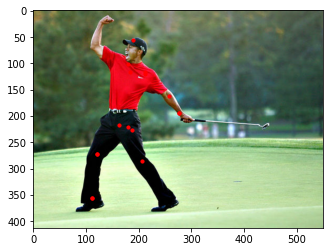

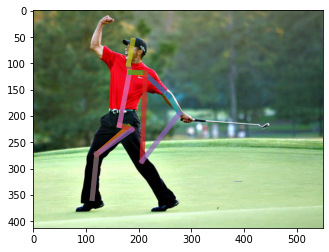

In [33]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

## 04. 회고

- 모델의 가중치를 가져오는 과정에서 오류가 많이 났었다. 학습시간이 오래걸리는데 오류가 나면 다시 복구하는데 많은 시간이 소모되었다.
- SBL 모델은 어떻게 해야하는지 감이 안잡힌다. 참고할만한 github도 부족했다.